<a href="https://colab.research.google.com/github/goralex02/time-series-project/blob/main/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Работа с временными рядами стоимости акций

Контрольное задание
1.	Найти три любых временных ряда, связанных между собой
Можно Составить портфель из 3 биржевых инструментов, сделать для них выборку биржевых данных за один месяц
2.	Выполнить статистический анализ данных Очистку данных, провести тестирование на стационарность, на коинтеграцию
3.	Выбрать в качестве основного один из рядов
4.	Построить  ARIMA  и ARMAX модель, вывести параметры, сравнить
5.	Построить две модели из семейства GARCH, вывести параметры, сравнить при разных p, q
6.	Построить VAR модель
7.	Построить 2  любых бустинговых модели (XGBoost, ThymeBoost, CatBoost)

Дополнительно:
8.	Построить модель на нейронных сетях

Примечание:  Работа должна содержать графики исходных сигналов и результатов моделирования


## 1.	Найти три любых временных ряда, связанных между собой
Можно Составить портфель из 3 биржевых инструментов, сделать для них выборку биржевых данных за один месяц

In [2]:
!pip install numpy==1.26.4

[*********************100%***********************]  3 of 3 completed


Datetime
0 days 01:00:00    138
0 days 18:00:00     18
2 days 18:00:00      4
Name: count, dtype: int64


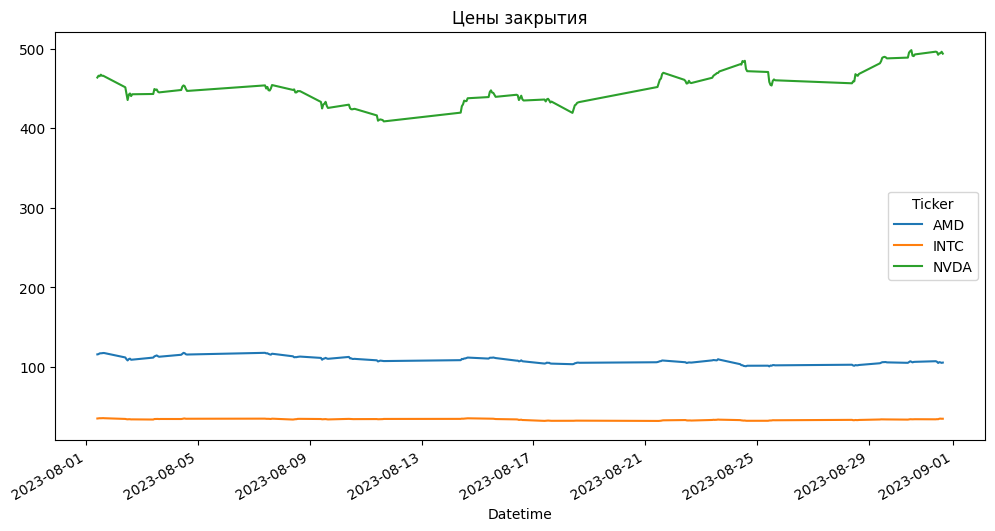

In [259]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных
tickers = ['NVDA', 'AMD', 'INTC']
data = yf.download(tickers, start='2023-08-01', end='2023-09-01', interval='1h')['Close']

data.index = data.index.tz_convert('America/New_York')
print(data.index.to_series().diff().value_counts())
from pandas.tseries.offsets import CustomBusinessHour
from pandas.tseries.holiday import USFederalHolidayCalendar

# Торговые часы (9:30 - 16:30)
bh = CustomBusinessHour(start='9:30', end='16:30', calendar=USFederalHolidayCalendar())

data = data.asfreq(bh)  # Заполняем недостающие часы



# Визуализация
data.plot(figsize=(12, 6))
plt.title('Цены закрытия')
plt.show()

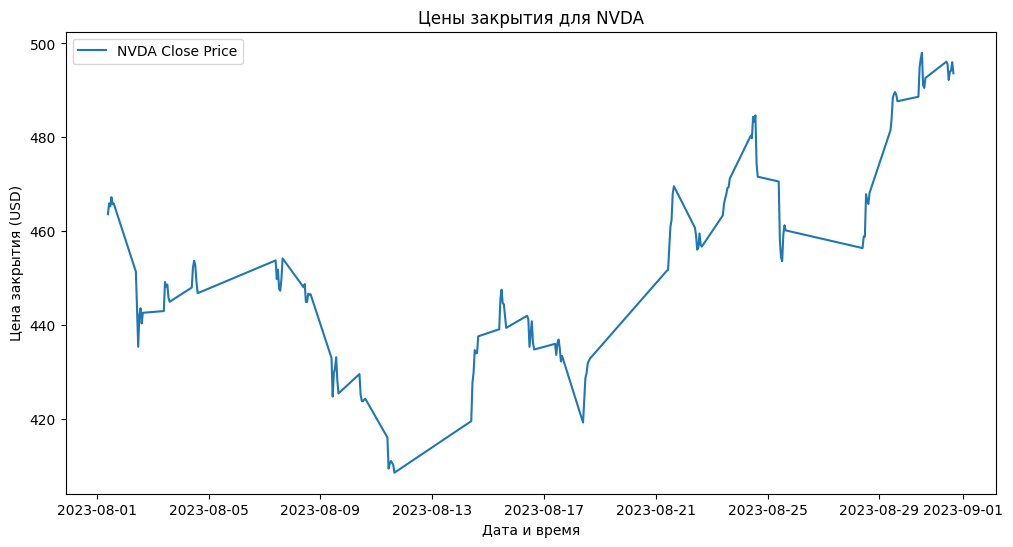

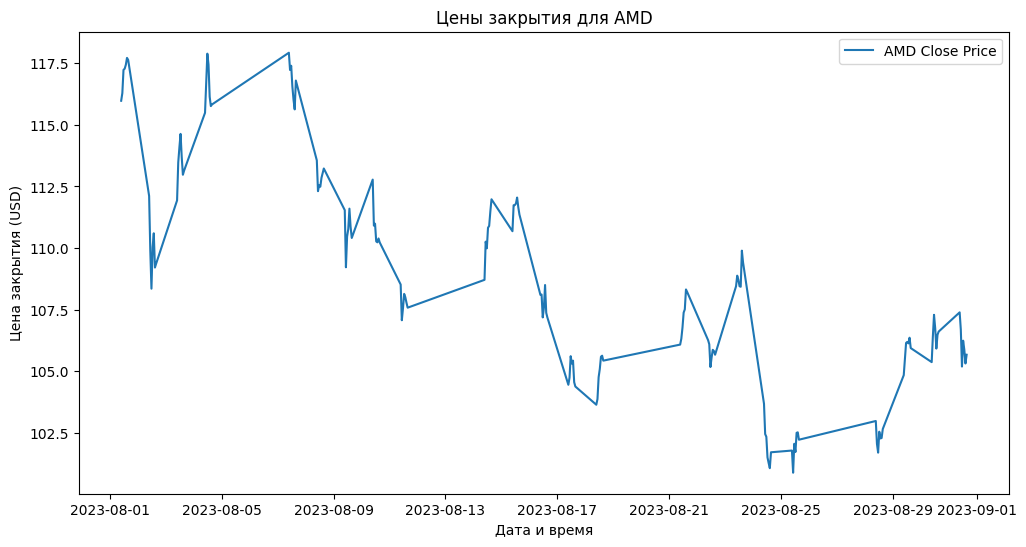

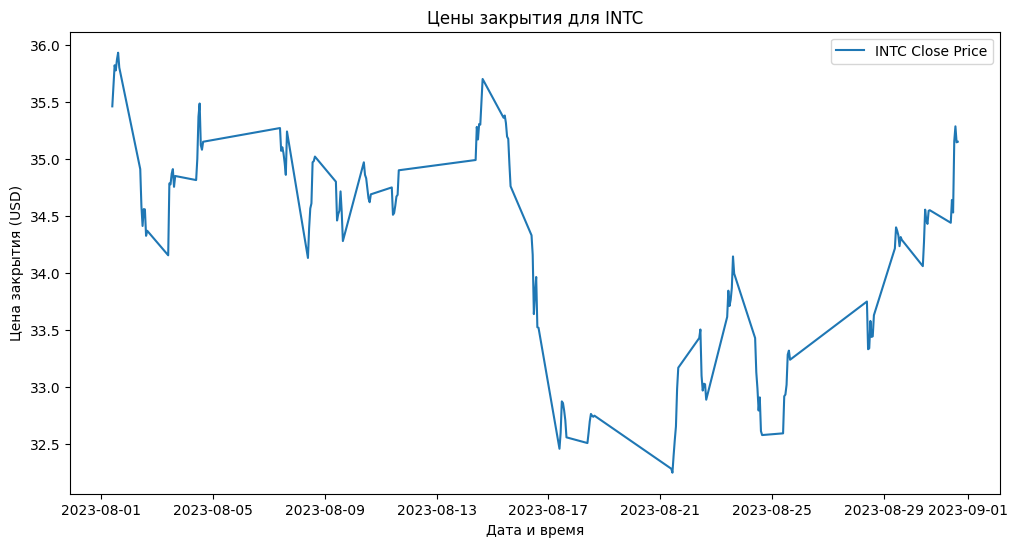

In [260]:
# Визуализация графиков для каждой акции
for ticker in tickers:
    plt.figure(figsize=(12, 6))
    plt.plot(data[ticker], label=f'{ticker} Close Price')
    plt.title(f'Цены закрытия для {ticker}')
    plt.xlabel('Дата и время')
    plt.ylabel('Цена закрытия (USD)')
    plt.legend()
    #plt.grid(True)
    plt.show()

In [261]:
# Проверим, есть ли даты, которые попадают на выходные
weekends = data.index[data.index.weekday >= 5]  # 5 = суббота, 6 = воскресенье
print(f"Количество записей в выходные: {len(weekends)}")
print(weekends)

Количество записей в выходные: 0
DatetimeIndex([], dtype='datetime64[ns, America/New_York]', name='Datetime', freq='cbh')


Посмотрим на скачанные данные

In [262]:
print(data.head())

Ticker                            AMD       INTC        NVDA
Datetime                                                    
2023-08-01 09:30:00-04:00  115.979897  35.459999  463.620087
2023-08-01 10:30:00-04:00  116.290001  35.639999  465.914093
2023-08-01 11:30:00-04:00  117.235001  35.820000  465.299988
2023-08-01 12:30:00-04:00  117.279999  35.775002  467.250000
2023-08-01 13:30:00-04:00  117.440002  35.869999  465.755005


In [263]:
print(data.tail())

Ticker                            AMD       INTC        NVDA
Datetime                                                    
2023-08-31 11:30:00-04:00  105.190002  34.529900  492.239990
2023-08-31 12:30:00-04:00  106.239899  35.154999  494.030212
2023-08-31 13:30:00-04:00  105.879997  35.285000  494.170013
2023-08-31 14:30:00-04:00  105.314499  35.145000  496.010010
2023-08-31 15:30:00-04:00  105.669998  35.150002  493.649994


## 2.	Выполнить статистический анализ данных Очистку данных, провести тестирование на стационарность, на коинтеграцию

In [264]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 161 entries, 2023-08-01 09:30:00-04:00 to 2023-08-31 15:30:00-04:00
Freq: cbh
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMD     161 non-null    float64
 1   INTC    161 non-null    float64
 2   NVDA    161 non-null    float64
dtypes: float64(3)
memory usage: 5.0 KB
None


Посмотрим на STL разложение для AMD

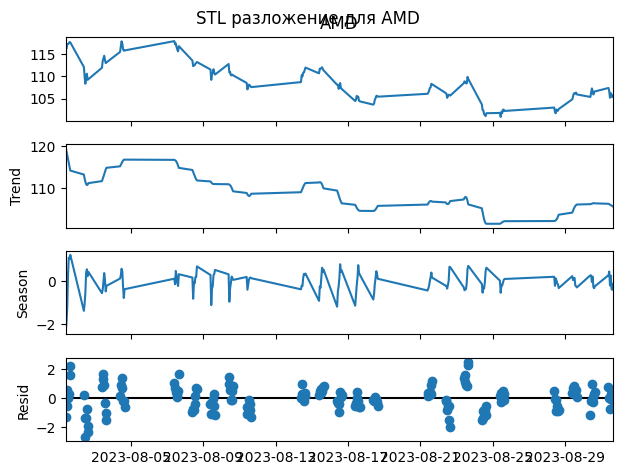

In [265]:
from statsmodels.tsa.seasonal import STL
# Анализ для AMD
ticker = 'AMD'
series = data[ticker]

# Разложение временного ряда с помощью STL, у нас 7 торговых часов в дне
stl = STL(series, seasonal=7, period=7)
result = stl.fit()

# Визуализация компонент
result.plot()
plt.suptitle(f'STL разложение для {ticker}')
plt.show()

Посмотрим на нормализованные ряды

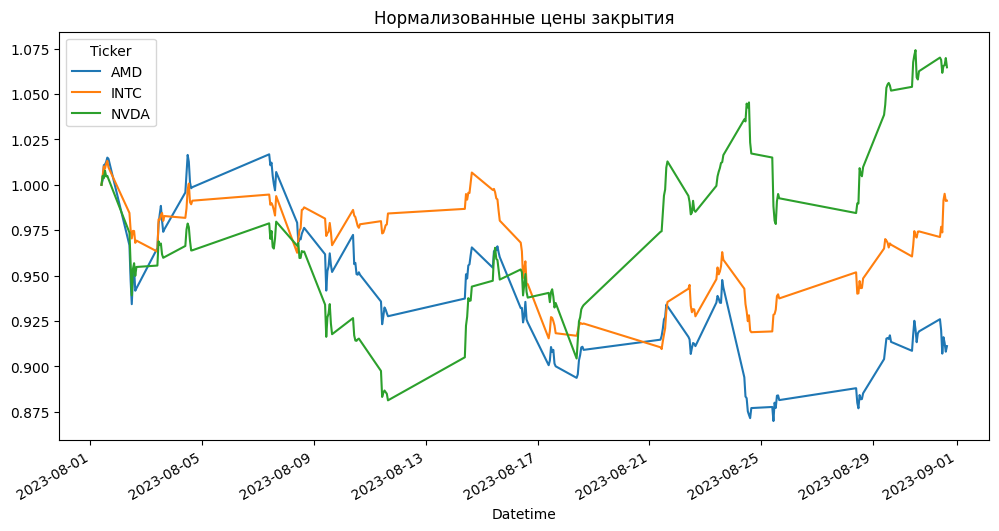

In [266]:
# Нормализация (приведение к одному масштабу, начало с 1)
normalized_data = data / data.iloc[0]
normalized_data.plot(figsize=(12, 6))
plt.title('Нормализованные цены закрытия')
plt.show()

Посмотрим наличие пропусков, дубликатов

In [267]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 161 entries, 2023-08-01 09:30:00-04:00 to 2023-08-31 15:30:00-04:00
Freq: cbh
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMD     161 non-null    float64
 1   INTC    161 non-null    float64
 2   NVDA    161 non-null    float64
dtypes: float64(3)
memory usage: 5.0 KB
None


In [268]:
print(data.AMD.info())

<class 'pandas.core.series.Series'>
DatetimeIndex: 161 entries, 2023-08-01 09:30:00-04:00 to 2023-08-31 15:30:00-04:00
Freq: cbh
Series name: AMD
Non-Null Count  Dtype  
--------------  -----  
161 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB
None


In [269]:
print(data.isnull().sum())

Ticker
AMD     0
INTC    0
NVDA    0
dtype: int64


In [270]:
print(data.duplicated().sum())

0


Посмотрим на основные статистические характеристики

In [271]:
print(data.describe())

Ticker         AMD        INTC        NVDA
count   161.000000  161.000000  161.000000
mean    108.787339   34.186695  452.446608
std       4.488584    0.958649   22.078484
min     100.879898   32.250000  408.549988
25%     105.610397   33.340000  435.369904
50%     108.220001   34.439999  449.181885
75%     111.742699   34.910000  465.914093
max     117.930000   35.930000  498.035004


Проверим наличие выбросов с помощью ящика с усами

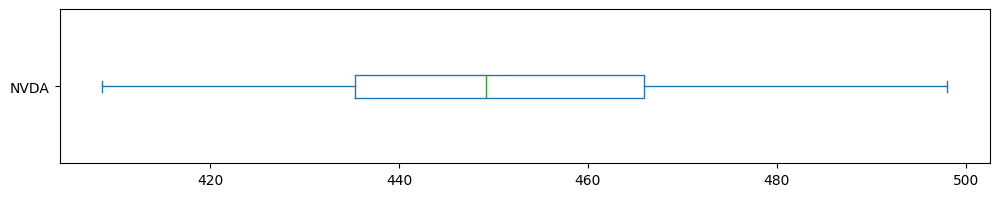

In [272]:
data.NVDA.plot.box(figsize=(12, 2), vert=False);

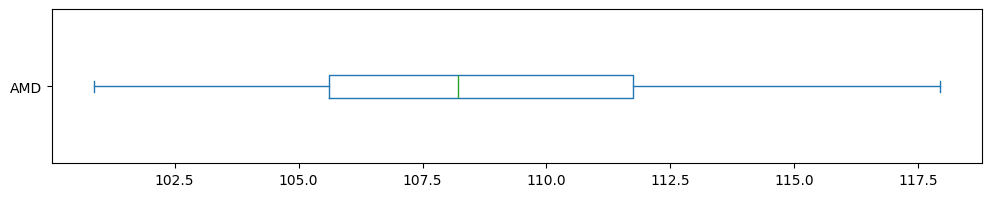

In [273]:
data.AMD.plot.box(figsize=(12, 2), vert=False);

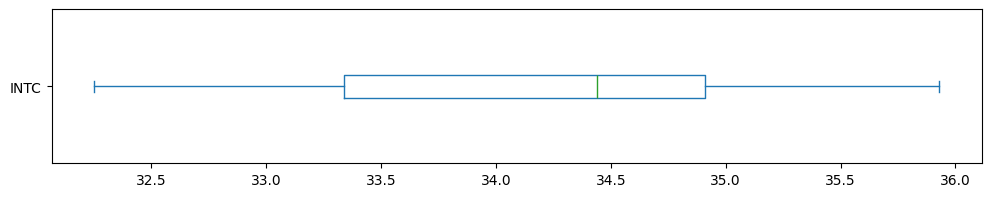

In [274]:
data.INTC.plot.box(figsize=(12, 2), vert=False);

Проверим корреляцию

In [275]:
# Корреляционная матрица
corr_matrix = data.corr()
print("Корреляция между рядами:")
print(corr_matrix)


Корреляция между рядами:
Ticker       AMD      INTC      NVDA
Ticker                              
AMD     1.000000  0.773503 -0.239029
INTC    0.773503  1.000000 -0.051289
NVDA   -0.239029 -0.051289  1.000000


Проведем тест Дики-Фуллера на стационарность рядов

In [276]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series, name):
    result = adfuller(series)
    print(f"Тест Дики-Фуллера для {name}:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Ряд стационарен.")
    else:
        print("Ряд нестационарен.")

for col in data.columns:
    test_stationarity(data[col], col)

Тест Дики-Фуллера для AMD:
ADF Statistic: -1.9754901200491748
p-value: 0.2974221325405673
Ряд нестационарен.
Тест Дики-Фуллера для INTC:
ADF Statistic: -1.8341645335028154
p-value: 0.36363666062353783
Ряд нестационарен.
Тест Дики-Фуллера для NVDA:
ADF Statistic: -0.8085687801520116
p-value: 0.8165920858924671
Ряд нестационарен.


Проведем этот же тест для дифференцированных рядов

In [277]:
data_diff = data.diff().dropna()

for col in data_diff.columns:
    test_stationarity(data_diff[col], f"{col} (дифференцированный)")

Тест Дики-Фуллера для AMD (дифференцированный):
ADF Statistic: -10.913009549241462
p-value: 1.0849372810651082e-19
Ряд стационарен.
Тест Дики-Фуллера для INTC (дифференцированный):
ADF Statistic: -12.57533160630082
p-value: 1.9631275447634628e-23
Ряд стационарен.
Тест Дики-Фуллера для NVDA (дифференцированный):
ADF Statistic: -5.067037561329616
p-value: 1.6324023359579108e-05
Ряд стационарен.


Посмотрим на дифференцированные цены закрытия

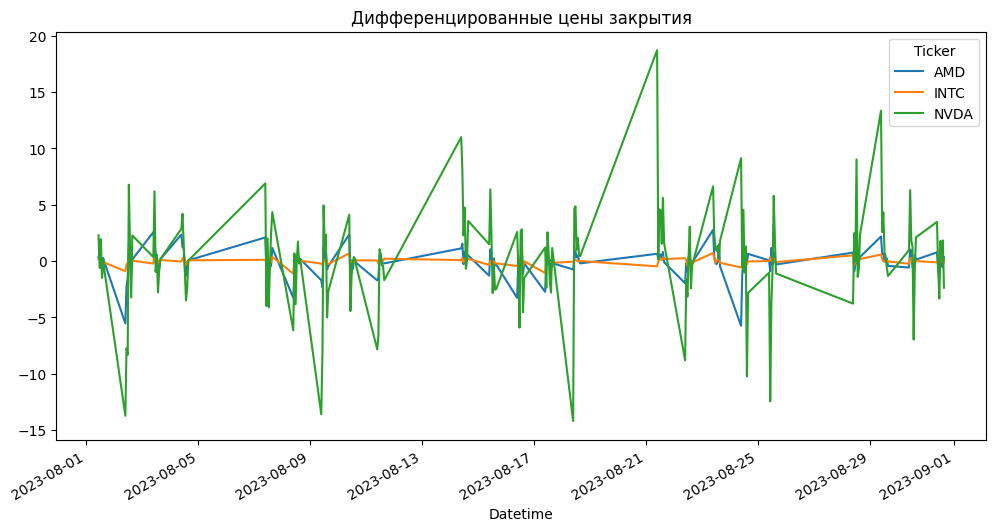

In [278]:
data_diff.plot(figsize=(12, 6))
plt.title('Дифференцированные цены закрытия')
plt.show()

In [279]:
print(data_diff.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 160 entries, 2023-08-01 10:30:00-04:00 to 2023-08-31 15:30:00-04:00
Freq: cbh
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMD     160 non-null    float64
 1   INTC    160 non-null    float64
 2   NVDA    160 non-null    float64
dtypes: float64(3)
memory usage: 5.0 KB
None


In [280]:
print(data_diff.head())

Ticker                          AMD      INTC      NVDA
Datetime                                               
2023-08-01 10:30:00-04:00  0.310104  0.180000  2.294006
2023-08-01 11:30:00-04:00  0.945000  0.180000 -0.614105
2023-08-01 12:30:00-04:00  0.044998 -0.044998  1.950012
2023-08-01 13:30:00-04:00  0.160004  0.094997 -1.494995
2023-08-01 14:30:00-04:00  0.279999  0.060001  0.158386


In [281]:
print(data_diff.tail())

Ticker                          AMD      INTC      NVDA
Datetime                                               
2023-08-31 11:30:00-04:00 -1.504997 -0.110100 -3.320007
2023-08-31 12:30:00-04:00  1.049896  0.625099  1.790222
2023-08-31 13:30:00-04:00 -0.359901  0.130001  0.139801
2023-08-31 14:30:00-04:00 -0.565498 -0.139999  1.839996
2023-08-31 15:30:00-04:00  0.355499  0.005001 -2.360016


Проведем тест Йохансена для проверки коинтеграции

In [282]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Тест Йохансена (лаг = 1)
result = coint_johansen(data, det_order=0, k_ar_diff=1)

# Вывод результатов
print("Критические значения (90%, 95%, 99%):\n", result.cvt)
print("Статистики теста:\n", result.lr1)

# Проверка гипотезы о наличии коинтеграции (на уровне 95%)
critical_value_95 = result.cvt[1, 1]  # Вторая строка — 95% уровень
if result.lr1[0] > critical_value_95:
    print("Есть коинтеграция (p < 0.05)")
else:
    print("Нет коинтеграции")

Критические значения (90%, 95%, 99%):
 [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Статистики теста:
 [1.26957308e+01 3.53122846e+00 4.81506459e-03]
Нет коинтеграции


Проверим коинтеграцию с пакетом statsmodels

In [283]:
from statsmodels.tsa.stattools import coint

def test_cointegration(series1, series2, name1, name2):
    score, p_value, _ = coint(series1, series2)
    print(f"Тест коинтеграции между {name1} и {name2}:")
    print(f"p-value: {p_value}")
    if p_value < 0.05:
        print("Ряды коинтегрированы.")
    else:
        print("Ряды не коинтегрированы.")

# Проверка коинтеграции для всех пар
pairs = [('NVDA', 'AMD'), ('NVDA', 'INTC'), ('AMD', 'INTC')]
for pair in pairs:
    test_cointegration(data[pair[0]], data[pair[1]], pair[0], pair[1])

Тест коинтеграции между NVDA и AMD:
p-value: 0.8180133366838498
Ряды не коинтегрированы.
Тест коинтеграции между NVDA и INTC:
p-value: 0.9183404529445545
Ряды не коинтегрированы.
Тест коинтеграции между AMD и INTC:
p-value: 0.8408225908225375
Ряды не коинтегрированы.


## 3.	Выбрать в качестве основного один из рядов

Можно взять AMD (он хорошо коррелирует с INTC и становится стационарным после дифференцирования).


## 4.	Построить  ARIMA  и ARMAX модель, вывести параметры, сравнить

Проверим автокорреляцию дифференцирования AMD

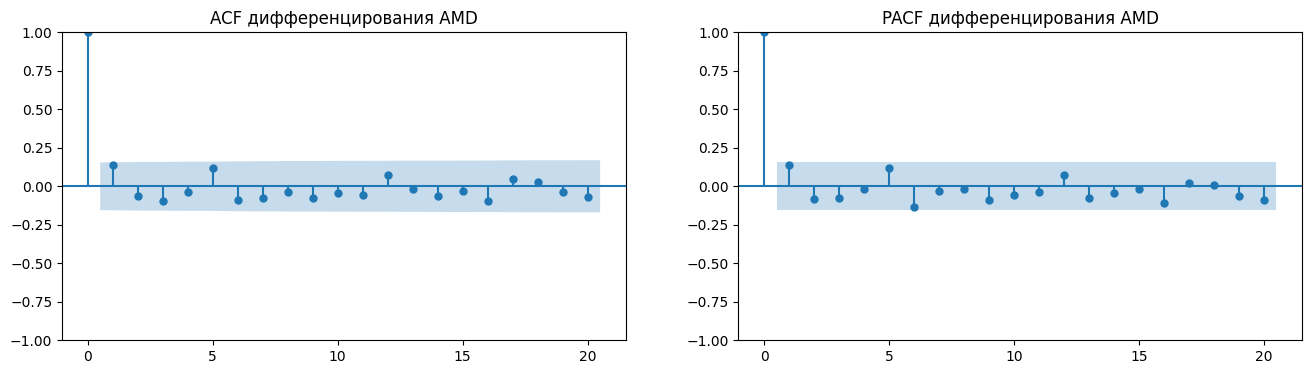

In [284]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

amd_diff = data_diff['AMD']

# Фигура для ACF и PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF
sm.graphics.tsa.plot_acf(amd_diff, lags=20, ax=axes[0])
axes[0].set_title('ACF дифференцирования AMD')

# PACF
sm.graphics.tsa.plot_pacf(amd_diff, lags=20, ax=axes[1], method='ywm')
axes[1].set_title('PACF дифференцирования AMD')

plt.show()

In [285]:
from statsmodels.tsa.arima.model import ARIMA

# Строим ARIMA модель
model_arima = ARIMA(data['AMD'], order=(1, 1, 1))
result_arima = model_arima.fit()

# Сводка модели
print(result_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                    AMD   No. Observations:                  161
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -249.835
Date:                Wed, 19 Mar 2025   AIC                            505.670
Time:                        14:59:06   BIC                            514.895
Sample:                    08-01-2023   HQIC                           509.416
                         - 08-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1920      0.579     -0.331      0.740      -1.328       0.944
ma.L1          0.3416      0.556      0.615      0.539      -0.747       1.431
sigma2         1.3296      0.077     17.181      0.0

Параметры:

ar.L1 (-0.1920): p-value = 0.74 → незначим. Авторегрессионная компонента (AR) не улучшает модель.

ma.L1 (0.3416): p-value = 0.539 → незначим. Скользящее среднее (MA) также не вносит вклад.

sigma2 (1.3296): Дисперсия ошибок модели.

Качество модели:

AIC = 505.67, BIC = 514.89: Высокие значения указывают на слабое качество модели.

Ljung-Box (Q): p-value = 0.97 → остатки не имеют автокорреляции (хорошо).

Jarque-Bera: p-value = 0.00 → остатки не нормальны (сильная асимметрия и куртозис).

Куртозис (8.82): Распределение остатков имеет "тяжелые хвосты" (выбросы).

In [286]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Берем регрессоры
exog = data[['INTC', 'NVDA']]

# Строим ARIMAX модель
model_arimax = SARIMAX(data['AMD'], exog=exog, order=(1, 1, 1))
result_arimax = model_arimax.fit()

# Сводка модели
print(result_arimax.summary())

                               SARIMAX Results                                
Dep. Variable:                    AMD   No. Observations:                  161
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -180.296
Date:                Wed, 19 Mar 2025   AIC                            370.592
Time:                        14:59:06   BIC                            385.968
Sample:                    08-01-2023   HQIC                           376.836
                         - 08-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
INTC           2.6624      0.189     14.120      0.000       2.293       3.032
NVDA           0.0826      0.010      8.016      0.000       0.062       0.103
ar.L1         -0.4708      1.538     -0.306      0.7

Параметры:

INTC (2.6624): p-value = 0.000 → значим. Рост INTC на 1 единицу связан с ростом AMD на ~2.66 единиц.

NVDA (0.0826): p-value = 0.000 → значим. Рост NVDA на 1 единицу связан с ростом AMD на ~0.08 единиц.

ar.L1 (-0.4708) и ma.L1 (0.5212): p-value > 0.7 → незначимы. AR/MA компоненты избыточны.

sigma2 (0.5575): Дисперсия ошибок ниже, чем в ARIMA → модель точнее.

Качество модели:

AIC = 370.59, BIC = 385.97: Значительно лучше ARIMA → экзогенные переменные улучшили модель.

Ljung-Box (Q): p-value = 0.69 → остатки не имеют автокорреляции (хорошо).

Jarque-Bera: p-value = 0.00 → остатки крайне ненормальны (куртозис 16.31).

Проверим остатки модели

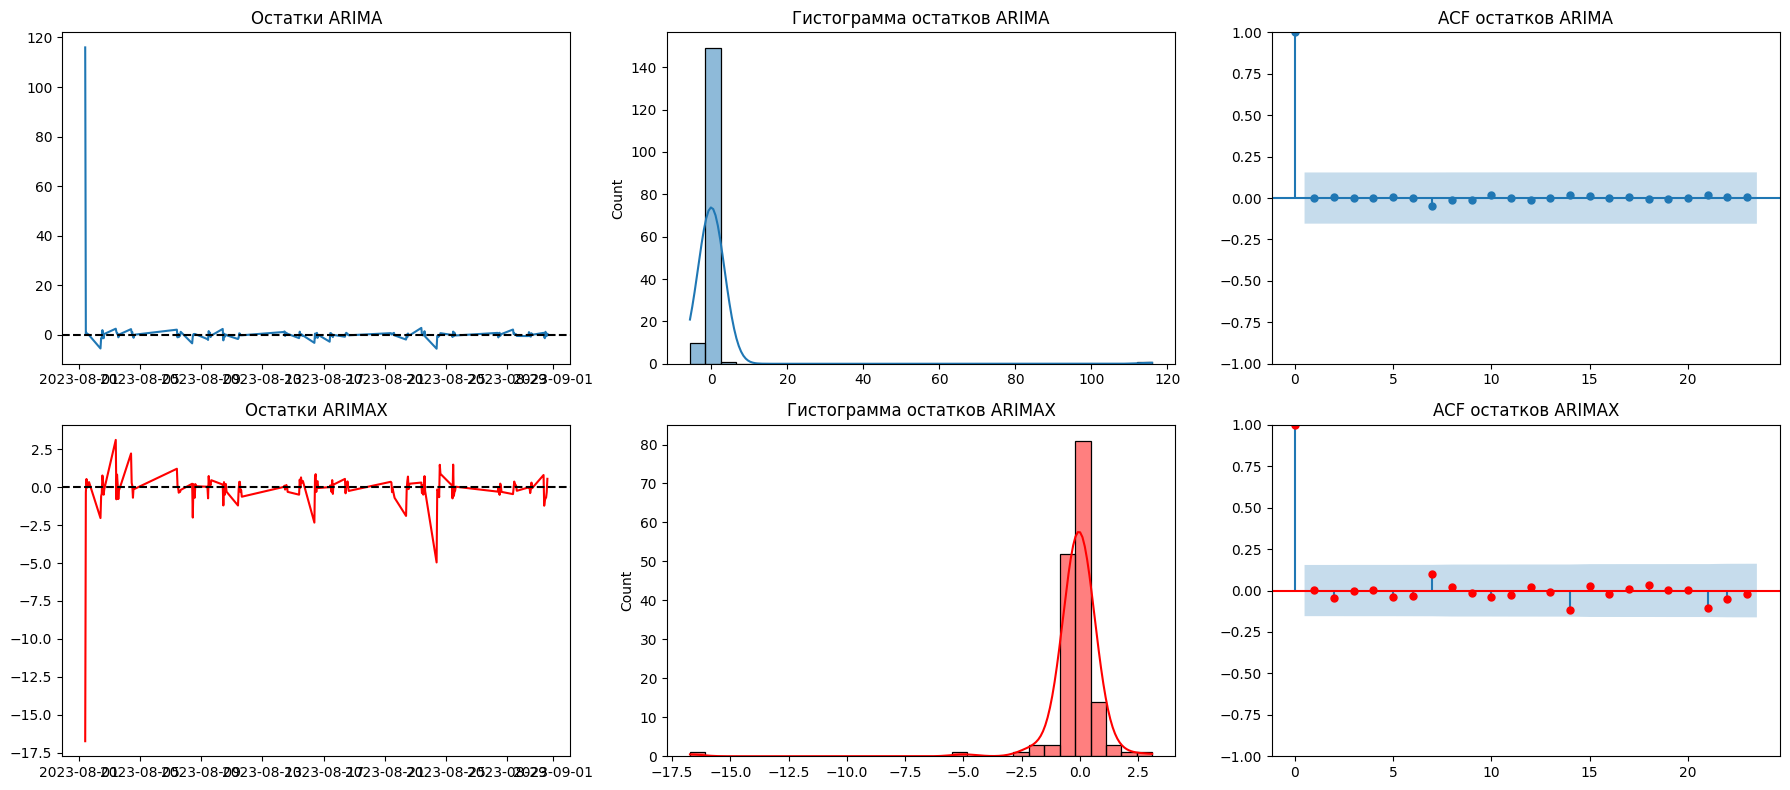

In [287]:
import seaborn as sns
import statsmodels.api as sm
# Получаем остатки модели
residuals_arima = result_arima.resid
residuals_arimax = result_arimax.resid

fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# 1. Временной ряд остатков ARIMA
axes[0, 0].plot(residuals_arima, label="Остатки ARIMA")
axes[0, 0].axhline(0, linestyle="--", color="black")
axes[0, 0].set_title("Остатки ARIMA")

# 2. Гистограмма остатков ARIMA
sns.histplot(residuals_arima, bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Гистограмма остатков ARIMA")

# 3. ACF остатков ARIMA
sm.graphics.tsa.plot_acf(residuals_arima, ax=axes[0, 2])
axes[0, 2].set_title("ACF остатков ARIMA")

# 4. Временной ряд остатков ARIMAX
axes[1, 0].plot(residuals_arimax, label="Остатки ARIMAX", color="red")
axes[1, 0].axhline(0, linestyle="--", color="black")
axes[1, 0].set_title("Остатки ARIMAX")

# 5. Гистограмма остатков ARIMAX
sns.histplot(residuals_arimax, bins=30, kde=True, ax=axes[1, 1], color="red")
axes[1, 1].set_title("Гистограмма остатков ARIMAX")

# 6. ACF остатков ARIMAX
sm.graphics.tsa.plot_acf(residuals_arimax, ax=axes[1, 2], color='red')
axes[1, 2].set_title("ACF остатков ARIMAX")

plt.tight_layout()
plt.show()

Проверим автокорреляцию остатков

In [288]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Для ARIMA
lb_test_arima = acorr_ljungbox(residuals_arima, lags=10)
print("ARIMA p-values:", lb_test_arima.iloc[:, 1].values)

# Для ARMAX
lb_test_armax = acorr_ljungbox(residuals_arimax, lags=10)
print("ARMAX p-values:", lb_test_armax.iloc[:, 1].values)

ARIMA p-values: [0.96865006 0.99429121 0.99965704 0.99998148 0.99999837 0.99999991
 0.99973385 0.99992675 0.99997856 0.99999315]
ARMAX p-values: [0.94503527 0.8486961  0.95462927 0.987821   0.98900525 0.99296242
 0.92346308 0.95453015 0.9757542  0.98279766]


 Все p-values > 0.05 → остатки не имеют автокорреляции.

Попробуем спрогнозировать значения ряда с помощью моделей

In [289]:
# Разделение на train/test
train_size = 130
train, test = data['AMD'][:train_size], data['AMD'][train_size:]

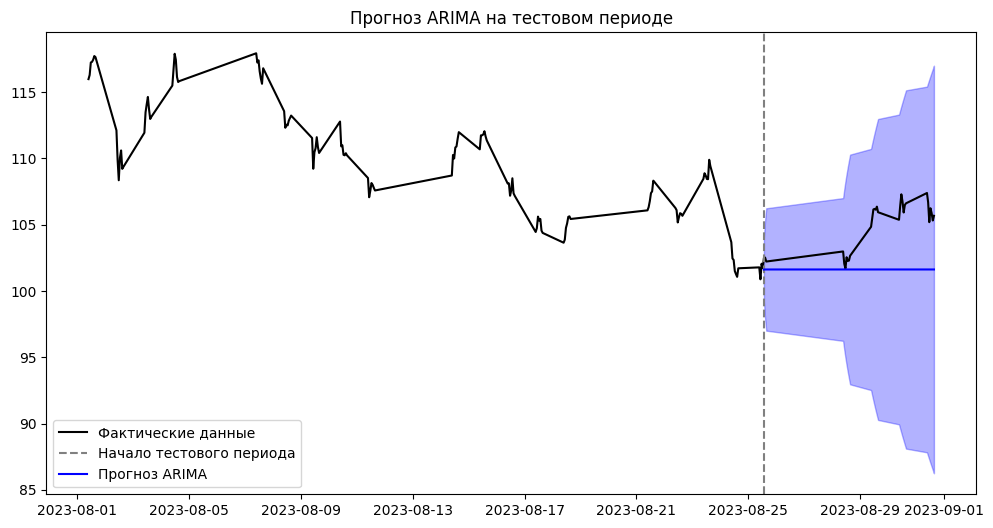

In [290]:
# Обучаем ARIMA только на train (без регрессоров)
model_arima_train = ARIMA(train, order=(1, 1, 1))
result_arima_train = model_arima_train.fit()

# Делаем прогноз на тестовые данные
forecast_arima = result_arima_train.get_forecast(steps=len(test))
forecast_arima_mean = forecast_arima.predicted_mean
forecast_arima_ci = forecast_arima.conf_int()

# Визуализация прогноза ARIMA
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['AMD'], label="Фактические данные", color="black")
plt.axvline(data.index[train_size], linestyle="--", color="gray", label="Начало тестового периода")
plt.plot(test.index, forecast_arima_mean, label="Прогноз ARIMA", color="blue")
plt.fill_between(test.index, forecast_arima_ci.iloc[:, 0], forecast_arima_ci.iloc[:, 1], color="blue", alpha=0.3)
plt.legend()
plt.title("Прогноз ARIMA на тестовом периоде")
plt.show()


Константный прогноз — это следствие:

Незначимых AR/MA параметров.

Стационарности данных.

In [291]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
mae_arima = mean_absolute_error(test, forecast_arima_mean)
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima_mean))

print(f"MAE ARIMA: {mae_arima:.4f}")
print(f"RMSE ARIMA: {rmse_arima:.4f}")

MAE ARIMA: 3.2836
RMSE ARIMA: 3.7616


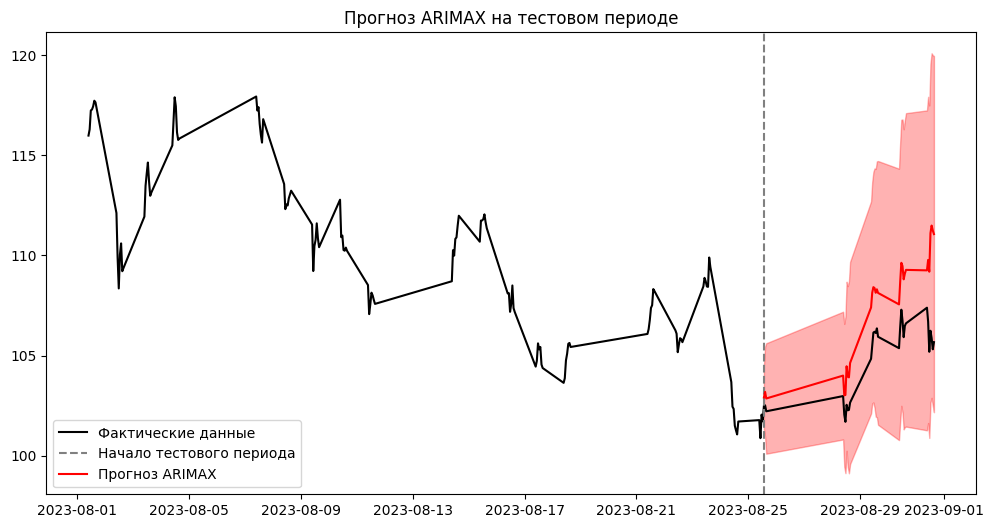

In [292]:
# Обучаем ARIMAX только на train
exog_train, exog_test = data[['INTC', 'NVDA']][:train_size], data[['INTC', 'NVDA']][train_size:]
model_arimax_train = SARIMAX(train, exog=exog_train, order=(1, 1, 1))
result_arimax_train = model_arimax_train.fit()

# Делаем прогноз на тест
forecast = result_arimax_train.get_forecast(steps=len(test), exog=exog_test)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['AMD'], label="Фактические данные", color="black")
plt.axvline(data.index[train_size], linestyle="--", color="gray", label="Начало тестового периода")
plt.plot(test.index, forecast_mean, label="Прогноз ARIMAX", color="red")
plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color="red", alpha=0.3)
plt.legend()
plt.title("Прогноз ARIMAX на тестовом периоде")
plt.show()

In [293]:
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test, forecast_mean)
rmse = np.sqrt(mean_squared_error(test, forecast_mean))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 2.4671
RMSE: 2.8248


Благодаря экзогенным переменным ARIMAX корректнее предсказывает значения ряда

## 5. Построить две модели из семейства GARCH, вывести параметры, сравнить при разных p, q

In [294]:
!pip install arch -q

Будем использовать логарифмическую доходность ввиду простоты использования

In [295]:
from arch import arch_model

# 1. Вычисляем логарифмическую доходность
data['AMD_log_return'] = np.log(data['AMD'] / data['AMD'].shift(1))

# 2. Удаляем NaN после сдвига
returns = data['AMD_log_return'].dropna()

# 3. Проверяем стационарность
adf_test = adfuller(returns)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")  # p-value < 0.05 → ряд стационарен

# 4. Разделяем данные на train/test
train_size = 130
train, test = returns[:train_size], returns[train_size:]

ADF Statistic: -10.934156338120339
p-value: 9.654399194381726e-20


Попробуем несколько разных вариантов моделей

In [296]:
garch_model = arch_model(returns, vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp='off')
print(garch_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:         AMD_log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                501.411
Distribution:                  Normal   AIC:                          -994.823
Method:            Maximum Likelihood   BIC:                          -982.522
                                        No. Observations:                  160
Date:                Wed, Mar 19 2025   Df Residuals:                      159
Time:                        14:59:12   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -5.8185e-04  5.310e-03     -0.110      0.

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001125. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [297]:
garch_model12 = arch_model(returns, vol='Garch', p=1, q=2)
garch_result12 = garch_model12.fit(disp='off')
print(garch_result12.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:         AMD_log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                501.872
Distribution:                  Normal   AIC:                          -993.744
Method:            Maximum Likelihood   BIC:                          -978.368
                                        No. Observations:                  160
Date:                Wed, Mar 19 2025   Df Residuals:                      159
Time:                        14:59:12   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -5.8452e-04  1.016e-03     -0.575      0.

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001125. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [298]:
garch_model21 = arch_model(returns, vol='Garch', p=2, q=1)
garch_result21 = garch_model21.fit(disp='off')
print(garch_result21.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:         AMD_log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                501.392
Distribution:                  Normal   AIC:                          -992.784
Method:            Maximum Likelihood   BIC:                          -977.408
                                        No. Observations:                  160
Date:                Wed, Mar 19 2025   Df Residuals:                      159
Time:                        14:59:12   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -6.0441e-04  9.776e-04     -0.618      0.

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001125. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [299]:
egarch_model = arch_model(returns, vol='EGarch', p=1, q=1)
egarch_result = egarch_model.fit(disp='off')
print(egarch_result.summary())

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001125. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - EGARCH Model Results                     
Dep. Variable:         AMD_log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                521.905
Distribution:                  Normal   AIC:                          -1035.81
Method:            Maximum Likelihood   BIC:                          -1023.51
                                        No. Observations:                  160
Date:                Wed, Mar 19 2025   Df Residuals:                      159
Time:                        14:59:12   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         6.2984e-04  2.719e-11  2.317e+07      0.000 [6.

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [300]:
egarch_model12 = arch_model(returns, vol='EGarch', p=1, q=2)
egarch_result12 = egarch_model12.fit(disp='off')
print(egarch_result12.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:         AMD_log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:           -4.32921e+07
Distribution:                  Normal   AIC:                       8.65842e+07
Method:            Maximum Likelihood   BIC:                       8.65842e+07
                                        No. Observations:                  160
Date:                Wed, Mar 19 2025   Df Residuals:                      159
Time:                        14:59:12   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         6.6671e-05  4.278e-06     15.586  9.031e-55 [5.

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001125. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [301]:
egarch_model21 = arch_model(returns, vol='EGarch', p=2, q=1)
egarch_result21 = egarch_model21.fit(disp='off')
print(egarch_result21.summary())

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001125. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - EGARCH Model Results                     
Dep. Variable:         AMD_log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                518.656
Distribution:                  Normal   AIC:                          -1027.31
Method:            Maximum Likelihood   BIC:                          -1011.94
                                        No. Observations:                  160
Date:                Wed, Mar 19 2025   Df Residuals:                      159
Time:                        14:59:12   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         4.2768e-04  4.166e-05     10.265  1.011e-24 [3.

In [302]:
gjr_model = arch_model(returns, vol='Garch', p=1, q=1, o=1)
gjr_result = gjr_model.fit(disp='off')
print(gjr_result.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:         AMD_log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                500.503
Distribution:                  Normal   AIC:                          -991.006
Method:            Maximum Likelihood   BIC:                          -975.630
                                        No. Observations:                  160
Date:                Wed, Mar 19 2025   Df Residuals:                      159
Time:                        14:59:12   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -6.6961e-04  1.745e-03     -0.384      0.

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001125. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Можно сравнить модели по следующим критериям:

AIC (Akaike Information Criterion): чем ниже, тем лучше.
BIC (Bayesian Information Criterion): чем ниже, тем лучше.
LLF (Log-Likelihood Function): чем выше, тем лучше.

In [303]:
comparison = pd.DataFrame({
    "Model": ["GARCH(1,1)", "GARCH(1,2)", "GARCH(2,1)", "EGARCH(1,1)", "EGARCH(1,2)", "EGARCH(2,1)", "GJR-GARCH(1,1)"],
    "AIC": [garch_result.aic, garch_result12.aic, garch_result21.aic, egarch_result.aic, egarch_result12.aic, egarch_result21.aic, gjr_result.aic],
    "BIC": [garch_result.bic, garch_result12.bic, garch_result21.bic, egarch_result.bic, egarch_result12.bic, egarch_result21.bic, gjr_result.bic],
    "Log-Likelihood": [garch_result.loglikelihood, garch_result12.loglikelihood, garch_result21.loglikelihood, egarch_result.loglikelihood, egarch_result12.loglikelihood, egarch_result21.loglikelihood, gjr_result.loglikelihood]
})

print(comparison)#.sort_values("AIC"))


            Model           AIC           BIC  Log-Likelihood
0      GARCH(1,1) -9.948226e+02 -9.825219e+02    5.014113e+02
1      GARCH(1,2) -9.937441e+02 -9.783682e+02    5.018721e+02
2      GARCH(2,1) -9.927839e+02 -9.774081e+02    5.013920e+02
3     EGARCH(1,1) -1.035811e+03 -1.023510e+03    5.219055e+02
4     EGARCH(1,2)  8.658419e+07  8.658420e+07   -4.329209e+07
5     EGARCH(2,1) -1.027312e+03 -1.011936e+03    5.186560e+02
6  GJR-GARCH(1,1) -9.910056e+02 -9.756297e+02    5.005028e+02


Лучшие результаты у модели EGARCH(1,1)

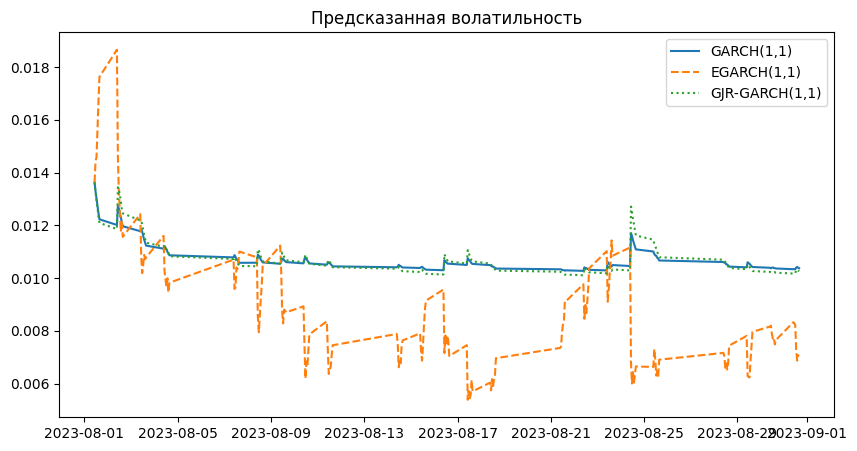

In [304]:
plt.figure(figsize=(10,5))
plt.plot(returns.index, garch_result.conditional_volatility, label="GARCH(1,1)")
plt.plot(returns.index, egarch_result.conditional_volatility, label="EGARCH(1,1)", linestyle='dashed')
plt.plot(returns.index, gjr_result.conditional_volatility, label="GJR-GARCH(1,1)", linestyle='dotted')
plt.title("Предсказанная волатильность")
plt.legend()
plt.show()


Попробуем предсказать волатильность с помощью лучшей модели

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001261. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001261. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - EGARCH Model Results                     
Dep. Variable:         AMD_log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                416.634
Distribution:                  Normal   AIC:                          -825.267
Method:            Maximum Likelihood   BIC:                          -813.797
                                        No. Observations:                  130
Date:                Wed, Mar 19 2025   Df Residuals:                      129
Time:                        14:59:13   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         7.8281e-04  1.637e-08  4.781e+04      0.000 [7.

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001251. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001242. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarn

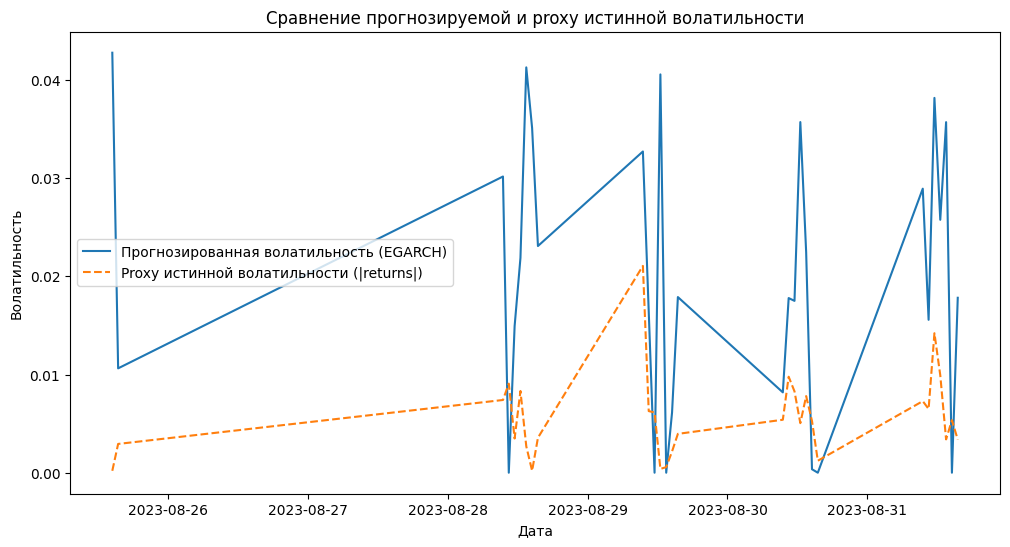

In [305]:
# Вычисляем лог-доходности
data['AMD_log_return'] = np.log(data['AMD'] / data['AMD'].shift(1))
returns = data['AMD_log_return'].dropna()

# Разбивка на обучающую и тестовую выборки
train_size = 130
train, test = returns[:train_size], returns[train_size:]

# Обучение EGARCH модели
egarch_model = arch_model(train, vol='EGarch', p=1, q=1)
egarch_result = egarch_model.fit(disp='off')
print(egarch_result.summary())

# Пошаговое прогнозирование
predicted_vol = []
history = train.copy()

for t in test.index:
    model = arch_model(history, vol='EGarch', p=1, q=1)
    result = model.fit(disp='off')
    forecast = result.forecast(horizon=1)

    # Берём корень из дисперсии и ограничиваем возможные выбросы
    vol = np.sqrt(forecast.variance.iloc[-1, 0])
    vol = np.clip(vol, 0, np.percentile(history.abs(), 99))  # Ограничение выбросов
    predicted_vol.append(vol)

    # Добавляем текущее значение в историю
    history.loc[t] = test.loc[t]

# Преобразуем список предсказаний в Series
predicted_vol = pd.Series(predicted_vol, index=test.index)

# В качестве proxy для истинной волатильности используем абсолютные значения доходностей тестовой выборки
realized_vol = test.abs()

# Визуализация: сравнение прогнозируемой и proxy истинной волатильности
plt.figure(figsize=(12, 6))
plt.plot(predicted_vol.index, predicted_vol, label='Прогнозированная волатильность (EGARCH)')
plt.plot(realized_vol.index, realized_vol, label='Proxy истинной волатильности (|returns|)', linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Волатильность')
plt.title('Сравнение прогнозируемой и proxy истинной волатильности')
plt.legend()
plt.show()

## 6.	Построить VAR модель

In [306]:
from statsmodels.tsa.api import VAR

# Используем дифференцированные данные
model = VAR(data_diff)

# Выбираем оптимальное число лагов (например, максимум 15)
lag_order_results = model.select_order(maxlags=15)
print(lag_order_results.summary())

# Определяем оптимальное число лагов по критерию AIC (или любому другому, например, BIC)
selected_lag = lag_order_results.selected_orders['aic']
print("Оптимальное число лагов (AIC):", selected_lag)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0     -0.5291*    -0.4675*     0.5892*    -0.5040*
1      -0.4312     -0.1848      0.6498     -0.3311
2      -0.3375     0.09365      0.7137     -0.1623
3      -0.2411      0.3748      0.7863    0.009195
4      -0.1372      0.6634      0.8730      0.1881
5      -0.1111      0.8743      0.8973      0.2893
6     -0.04810       1.122      0.9574      0.4274
7      -0.2733       1.082      0.7662      0.2772
8      -0.1924       1.347      0.8336      0.4332
9      -0.1375       1.587      0.8844      0.5632
10    -0.05564       1.854      0.9651      0.7201
11     0.03918       2.133       1.068      0.8900
12      0.1272       2.406       1.176       1.053
13      0.1762       2.640       1.246       1.177
14      0.1941       2.842       1.283       1.270
15      0.2488       3.082       1.373       1.400
-------------------------------

Странно строить модель с числом лагов 0, поробуем с числом лагов равным 3

In [307]:
# Подгоняем модель с выбранным числом лагов
selected_lag=3
model_fitted = model.fit(selected_lag)
print(model_fitted.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, Mar, 2025
Time:                     14:59:18
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   0.487325
Nobs:                     157.000    HQIC:                  0.140510
Log likelihood:          -630.731    FPE:                   0.908325
AIC:                   -0.0966715    Det(Omega_mle):        0.754728
--------------------------------------------------------------------
Results for equation AMD
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const          -0.067804         0.096840           -0.700           0.484
L1.AMD          0.175112         0.129192            1.355           0.175
L1.INTC        -0.331743         0.523491           -0.634           0.526
L1.NVDA    

Построим графики влияния шоков одной величины на другую

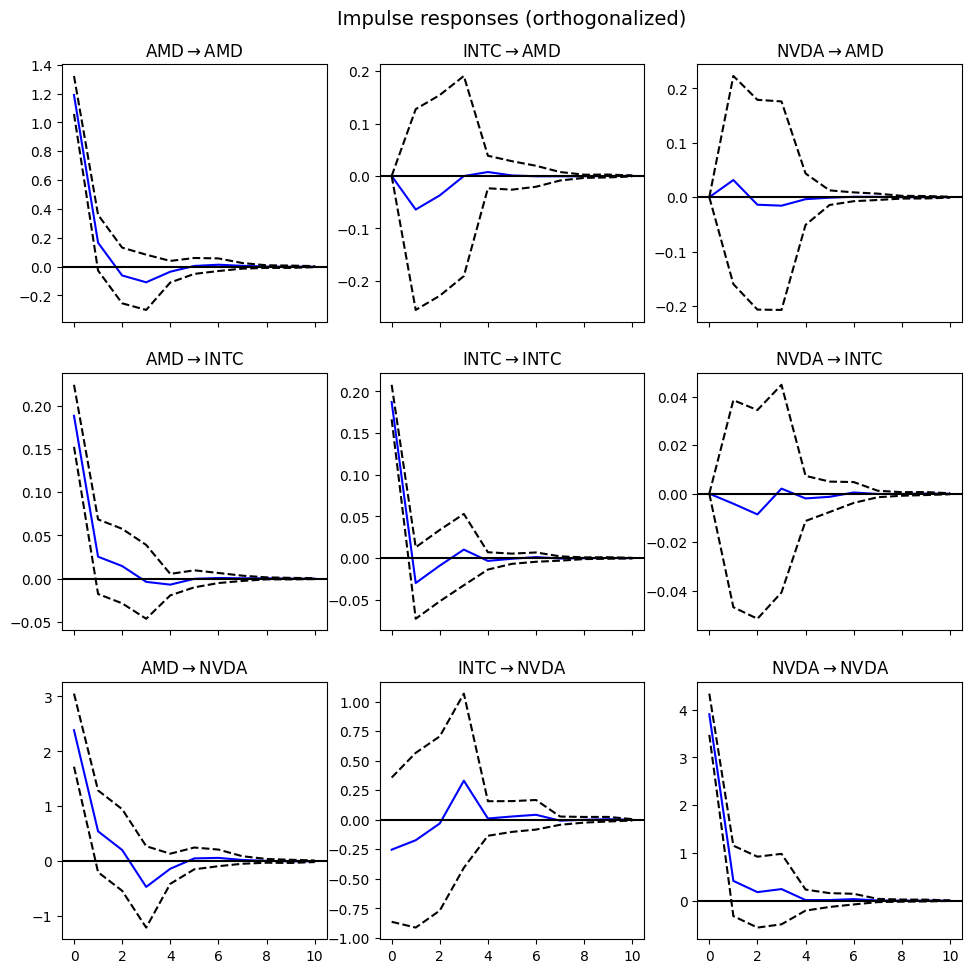

In [308]:
import matplotlib.pyplot as plt

# Рассчёт IRF на 10 периодов вперёд
irf = model_fitted.irf(10)
irf.plot(orth=True)
plt.show()

Структура графика:

Каждая панель (подграфик) показывает влияние одного временного ряда на другой.
По диагонали расположены графики типа "сам на себя" (например, AMD → AMD).
Остальные панели показывают перекрёстные влияния (например, AMD → INTC, INTC → NVDA).
Что означают линии?

Синяя линия — среднее значение отклика (влияние шока).
Чёрные пунктирные линии — доверительный интервал (обычно 95%).
Как интерпретировать отклики?

Если синяя линия уходит в плюс, то шок в первом ряду вызывает рост второго ряда.
Если синяя линия уходит в минус, то шок в первом ряду вызывает падение второго ряда.
Если доверительный интервал (чёрные линии) пересекает 0, влияние шока может быть статистически незначимым.
Влияние обычно затухает через несколько шагов.
Интерпретация результатов:
AMD → AMD (верхний левый график):

В начале резкий скачок вверх, затем влияние затухает. Это логично: если в AMD произошёл резкий рост, он постепенно возвращается к среднему.
INTC → AMD и NVDA → AMD (верхний ряд, средний и правый графики):

Влияние небольшое, и доверительный интервал широкий (шок INTC или NVDA слабо влияет на AMD).
AMD → INTC и INTC → INTC (средний ряд, левый и средний графики):

AMD оказывает небольшое влияние на INTC, но быстро затухающее.
Шок INTC влияет на сам себя, но также быстро возвращается к нулю.
AMD → NVDA (нижний левый график):

Всплеск в первую пару периодов, затем постепенное затухание.
Значит, изменения в AMD могут временно повлиять на NVDA.
NVDA → NVDA (нижний правый график):

Сильный скачок вверх и постепенный спад.
Это ожидаемо: шок в NVDA сначала сильно влияет на сам себя.
Основные выводы:
AMD, INTC и NVDA взаимосвязаны, но с разной силой.
AMD → NVDA имеет более сильное влияние, чем AMD → INTC.
NVDA наиболее волатильна (резкие движения вверх и вниз).
INTC оказывает слабое влияние на другие акции.
Если цель – предсказать поведение одного из активов, стоит учитывать, что AMD и NVDA реагируют сильнее, чем INTC.

In [309]:
# Получаем последние значения для формирования прогнозного интервала
lag_order = selected_lag
forecast_input = data_diff.values[-lag_order:]
forecast = model_fitted.forecast(y=forecast_input, steps=10)
print(forecast)

[[ 0.02184717  0.01977829  0.58174245]
 [-0.0335619   0.0107636   0.39243649]
 [-0.09336595 -0.00910881 -0.2553766 ]
 [-0.09074553 -0.00355757  0.11914692]
 [-0.07535488 -0.00332058  0.15194285]
 [-0.0694659  -0.00471859  0.14814008]
 [-0.07046127 -0.00349886  0.18099595]
 [-0.07165905 -0.00364467  0.1729375 ]
 [-0.07256392 -0.0039834   0.16500991]
 [-0.07266816 -0.00387677  0.16873526]]


## 7.	Построить 2  любых бустинговых модели (XGBoost, ThymeBoost, CatBoost)

In [310]:
!pip install catboost -q

Для ипользования ряда в качестве табличного ML добавим некоторые новые признаки

In [311]:
df = data.copy()
# Добавляем лаги для AMD
for lag in range(1, 6):  # 5 лагов
    df[f'AMD_lag_{lag}'] = df['AMD'].shift(lag)

# Скользящее среднее и стандартное отклонение
df['AMD_rolling_mean'] = df['AMD'].rolling(window=5).mean()
df['AMD_rolling_std'] = df['AMD'].rolling(window=5).std()

# Добавляем INTC и NVDA в качестве регрессоров
df['INTC_lag_1'] = df['INTC'].shift(1)
df['NVDA_lag_1'] = df['NVDA'].shift(1)

# Удаляем пропущенные значения
df.dropna(inplace=True)

# Разделение на train/test
train_size = 130
train, test = df.iloc[:train_size], df.iloc[train_size:]
X_train, y_train = train.drop(columns=['AMD']), train['AMD']
X_test, y_test = test.drop(columns=['AMD']), test['AMD']

Посмотрим на итоговый датасет

In [312]:
print(df.head())

Ticker                            AMD       INTC        NVDA  AMD_log_return  \
Datetime                                                                       
2023-08-01 14:30:00-04:00  117.720001  35.930000  465.913391        0.002381   
2023-08-01 15:30:00-04:00  117.640099  35.799999  465.125000       -0.000679   
2023-08-02 09:30:00-04:00  112.114998  34.910000  451.399994       -0.048105   
2023-08-02 10:30:00-04:00  109.894897  34.584999  443.667908       -0.020001   
2023-08-02 11:30:00-04:00  108.351501  34.411999  435.369904       -0.014144   

Ticker                      AMD_lag_1   AMD_lag_2   AMD_lag_3   AMD_lag_4  \
Datetime                                                                    
2023-08-01 14:30:00-04:00  117.440002  117.279999  117.235001  116.290001   
2023-08-01 15:30:00-04:00  117.720001  117.440002  117.279999  117.235001   
2023-08-02 09:30:00-04:00  117.640099  117.720001  117.440002  117.279999   
2023-08-02 10:30:00-04:00  112.114998  117.640099  117

Обучим XGBoost

In [313]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Обучаем XGBoost
xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

# Предсказания
y_pred_xgb = xgb_model.predict(X_test)

# Оценка качества
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost MAE: {mae_xgb}")


XGBoost MAE: 1.4173484215369592


Обучим CatBoost

In [314]:
from catboost import CatBoostRegressor

# Обучаем CatBoost
cat_model = CatBoostRegressor(iterations=200, learning_rate=0.05, depth=6, verbose=0)
cat_model.fit(X_train, y_train)

# Предсказания
y_pred_cat = cat_model.predict(X_test)

# Оценка качества
mae_cat = mean_absolute_error(y_test, y_pred_cat)
print(f"CatBoost MAE: {mae_cat}")


CatBoost MAE: 0.9315080229600596


Видно, что в данном случае CatBoost оказался лучше по МАЕ

In [315]:
print(f"XGBoost MAE: {mae_xgb}")
print(f"CatBoost MAE: {mae_cat}")


XGBoost MAE: 1.4173484215369592
CatBoost MAE: 0.9315080229600596


Сравним предсказания с реальными значениями

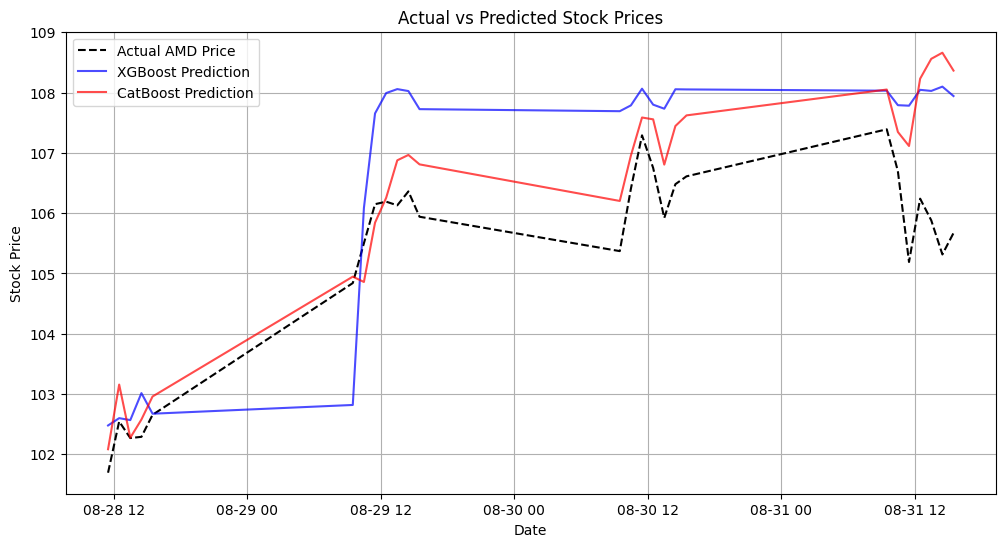

In [316]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label="Actual AMD Price", color='black', linestyle='dashed')
plt.plot(test.index, y_pred_xgb, label="XGBoost Prediction", color='blue', alpha=0.7)
plt.plot(test.index, y_pred_cat, label="CatBoost Prediction", color='red', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.grid()
plt.show()


Посмотрим на график остатков

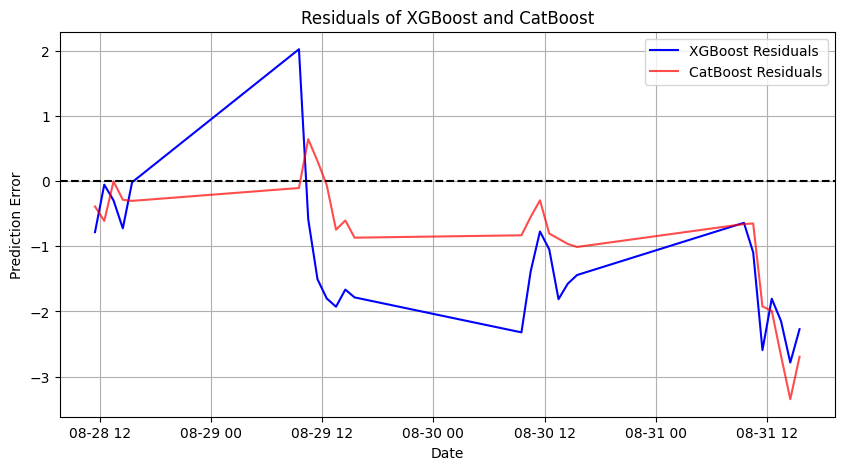

In [317]:
plt.figure(figsize=(10, 5))
plt.plot(test.index, y_test - y_pred_xgb, label="XGBoost Residuals", color='blue')
plt.plot(test.index, y_test - y_pred_cat, label="CatBoost Residuals", color='red', alpha=0.7)
plt.axhline(0, color='black', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Prediction Error")
plt.title("Residuals of XGBoost and CatBoost")
plt.legend()
plt.grid()
plt.show()


## 8.	Построить модель на нейронных сетях

Используем модель LSTM

In [318]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

df = data.copy()
# Выбираем основной ряд (AMD)
data = df["AMD"].values.reshape(-1, 1)

#Нормализуем
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Функция для создания окон данных
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Создаём последовательности
seq_length = 10  # Можно варьировать
X, y = create_sequences(data_scaled, seq_length)

# Разделяем на train/test
train_size = 130
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Преобразуем в тензоры
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Создаём DataLoader
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=16, shuffle=False)

In [319]:
# Определяем LSTM-модель
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

# Инициализируем модель
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Проверим форму X_train

In [320]:
print("Форма X_train:", X_train_tensor.shape)  # Ожидается (batch_size, seq_length, число_признаков)


Форма X_train: torch.Size([130, 10, 1])


Обучим модель

In [321]:
# Обучение модели
epochs = 50
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.0628
Epoch 10, Loss: 0.0338
Epoch 20, Loss: 0.0382
Epoch 30, Loss: 0.0235
Epoch 40, Loss: 0.0293


Сравним предсказания и реальные данные

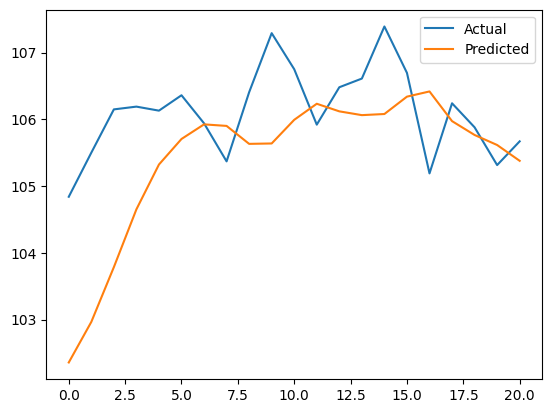

In [323]:
# Тестирование модели
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

# Обратное преобразование и оценка
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Визуализация результатов
import matplotlib.pyplot as plt
plt.plot(y_test_actual, label="Actual")
plt.plot(y_pred_actual, label="Predicted")
plt.legend()
plt.show()

Оценим MAE

In [324]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test_actual, y_pred_actual)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Mean Absolute Error (MAE): 0.9141


Ошибка оказалсь чуть ниже, чем у CatBoost